In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from sklearn.preprocessing import Normalizer, MinMaxScaler, minmax_scale

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
df_train = pd.read_csv('archive/fashion-mnist_train.csv') # df for dataframe
df_test = pd.read_csv('archive/fashion-mnist_test.csv')

labels_train = df_train.pop('label')
labels_test = df_test.pop('label')
#labels_train

In [3]:
normalize = MinMaxScaler() # choose transform
normalize.fit(df_train); # fit transform
df_train_normalized = np.single(normalize.transform(df_train)) # is np.single() command necessary? 
df_test_normalized = np.single(normalize.transform(df_test))

In [4]:
X_train = df_train_normalized.reshape(-1,28*28,)
X_test = df_test_normalized.reshape(-1,28*28,)

In [5]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K

In [6]:
original_dim = 28*28
intermediate_dim = 196
latent_dim = 6

In [8]:
inputs = tf.keras.Input(shape=(original_dim,))
h = tf.keras.layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = tf.keras.layers.Dense(latent_dim)(h)
z_log_sigma = tf.keras.layers.Dense(latent_dim)(h)

In [10]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = tf.keras.layers.Lambda(sampling)([z_mean, z_log_sigma])

In [12]:
# Create encoder
encoder = tf.keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = tf.keras.Input(shape=(latent_dim,), name='z_sampling')
x = tf.keras.layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = tf.keras.layers.Dense(original_dim, activation='sigmoid')(x)
decoder = tf.keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = tf.keras.Model(inputs, outputs, name='vae_mlp')

In [13]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, min_delta=0.10)
batch_size=32
vae.fit(X_train, X_train,
        epochs=50,
        batch_size=batch_size,
        callbacks=[early_stopping],
        validation_data=(X_test, X_test))

Epoch 1/100
1875/1875 [==============================] - 9s 5ms/step - loss: 287.5561 - val_loss: 242.4336
Epoch 2/100
1875/1875 [==============================] - 8s 4ms/step - loss: 242.0057 - val_loss: 238.1177
Epoch 3/100
1875/1875 [==============================] - 8s 4ms/step - loss: 237.9445 - val_loss: 235.7474
Epoch 4/100
1875/1875 [==============================] - 8s 4ms/step - loss: 236.1381 - val_loss: 234.3909
Epoch 5/100
1875/1875 [==============================] - 8s 4ms/step - loss: 234.4031 - val_loss: 233.3571
Epoch 6/100
1875/1875 [==============================] - 8s 4ms/step - loss: 234.0468 - val_loss: 232.5222
Epoch 7/100
1875/1875 [==============================] - 8s 4ms/step - loss: 232.8429 - val_loss: 232.3040
Epoch 8/100
1875/1875 [==============================] - 8s 4ms/step - loss: 233.1044 - val_loss: 231.6496
Epoch 9/100
1875/1875 [==============================] - 8s 4ms/step - loss: 232.0141 - val_loss: 231.3114
Epoch 10/100
1875/1875 [=============

KeyboardInterrupt: 

In [18]:
import matplotlib.pyplot as plt

In [19]:
X_test_encoded = encoder.predict(X_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(X_test_encoded[:, 0], X_test_encoded[:, 1], c=labels_test)
plt.colorbar()
plt.show()

TypeError: list indices must be integers or slices, not tuple

In [21]:
encoded_imgs = encoder.predict(X_test)
decoded_imgs = decoder.predict(encoded_imgs[2])

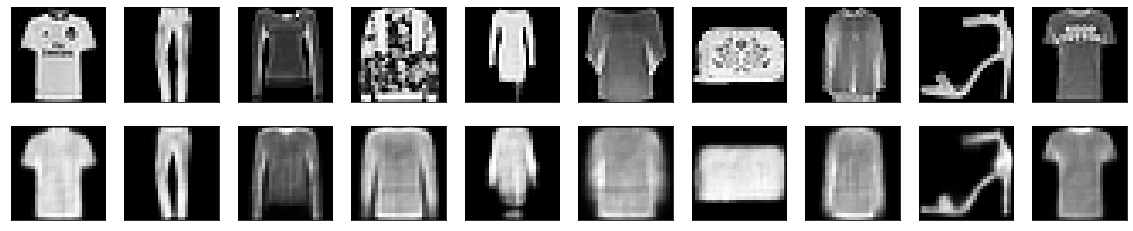

In [23]:
n = 10  # how many images we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [25]:
K.mean(tf.keras.losses.binary_crossentropy(X_test, decoded_imgs))

<tf.Tensor: shape=(), dtype=float32, numpy=0.28880447>